### IMPORTING THE LIBRARIES

1. DATA HANDLING

In [1]:
import pandas as pd
import numpy as np

2. DATA PRE PROCESSING

In [2]:
from ast import literal_eval
from sklearn.preprocessing import MultiLabelBinarizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import text, sequence
from keras.preprocessing.sequence import pad_sequences

3. MODELS 

In [3]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Embedding, Flatten, GlobalMaxPool1D, Conv1D, Input
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.losses import binary_crossentropy
from keras.optimizers import Adam
import tensorflow as tf
from sklearn.metrics import average_precision_score, recall_score, f1_score, precision_score

4. SAVING THE MODEL

In [4]:
import joblib

### DATASET

In [5]:
# Loading preprocessed dataset
file_path = "/Users/lalitaneeharikavajjhala/Desktop/Research credits /Data/preprocessed_data.csv"
df = pd.read_csv(file_path)

In [6]:
# Previewing data head and extend the max column width
pd.set_option('display.max_colwidth', None)
df.head()

,tag,sentence
0,['obligation'],we will issue a certificate of completion for each manager trainee who completes the initial training program we require to our satisfaction each such person will be referred to a a certified manager
1,['obligation'],elephant talk bear the risk of and shall indemnify against high usage fraud and bed of it elephant talk customer
2,['obligation'],subject to the term and condition of this agreement aimmune shall be responsible for the development of the product a set forth herein aimmune itself or with or through it affiliate and sublicensees shall use commercially reasonable effort to perform the development activity for the product to i achieve the development milestone set forth in section and ii obtain regulatory approval for the product
3,['obligation'],ediets shall ensure that the ediets content complies with editorial guideline
4,['obligation'],auriemma will participate in one recording session annually during the service period of not more than two hour not including travel time to record a radio advertising spot at a date and location to be mutually agreed upon


In [7]:
# Converting tags from strings to lists
df['tag'] = df['tag'].apply(lambda x: literal_eval(x))

In [8]:
# Encoding tags 'y'
y = df['tag']
multilabel = MultiLabelBinarizer()
y = multilabel.fit_transform(y)
y

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1]])

In [9]:
# Standard keras pre-processing
maxlen = 200 # Highest word count is 691 and mean is 52; however, 691 is an outlier
max_words = 2000
tokenizer = Tokenizer(num_words=max_words, lower=True)
tokenizer.fit_on_texts(df.sentence)

# Functions to transform text to feature_vectors 
def get_features(text_series):
    sequences = tokenizer.texts_to_sequences(text_series)
    return pad_sequences(sequences, maxlen=maxlen)

In [10]:
# Calling function to create features 'X'
X = get_features(df.sentence)

# Transforming y
y = multilabel.transform(df.tag)

print(X.shape, y.shape)

(947, 200) (947, 3)


In [11]:
X

array([[  0,   0,   0, ...,   8, 577, 372],
       [  0,   0,   0, ..., 105, 106, 109],
       [  0,   0,   0, ...,  19,   1,  31],
       ...,
       [  0,   0,   0, ...,  14,  11,  37],
       [  0,   0,   0, ...,   1,  12,   9],
       [  0,   0,   0, ..., 276,   5, 238]], dtype=int32)

MODEL DEVELOPMENT

In [12]:
# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0, shuffle=True, stratify=y)

In [13]:
# Modelling - Convolutional Neural Network
filter_length = 300
num_classes = 3 #so that the final layer is capable of outputting multiple labels

model = Sequential()
model.add(Embedding(max_words, 20, input_length=maxlen))
model.add(Dropout(0.1))
model.add(Conv1D(filter_length, 3, padding='valid', activation='relu', strides=1))
model.add(GlobalMaxPool1D())
model.add(Dense(num_classes))
model.add(Activation('sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 20)           40000     
                                                                 
 dropout (Dropout)           (None, 200, 20)           0         
                                                                 
 conv1d (Conv1D)             (None, 198, 300)          18300     
                                                                 
 global_max_pooling1d (Glob  (None, 300)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 3)                 903       
                                                                 
 activation (Activation)     (None, 3)                 0         
                                                        

In [14]:
# Fitting the model
callbacks = [
    ReduceLROnPlateau(), 
    EarlyStopping(patience=4)
]

history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    callbacks=callbacks)

Epoch 1/20
24/24 [==============================] - 0s 6ms/step - loss: 0.6713 - categorical_accuracy: 0.4095 - lr: 0.0010
Epoch 2/20
24/24 [==============================] - 0s 6ms/step - loss: 0.6512 - categorical_accuracy: 0.5456 - lr: 0.0010
Epoch 3/20
24/24 [==============================] - 0s 6ms/step - loss: 0.6237 - categorical_accuracy: 0.5390 - lr: 0.0010
Epoch 4/20
24/24 [==============================] - 0s 6ms/step - loss: 0.5653 - categorical_accuracy: 0.6803 - lr: 0.0010
Epoch 5/20
24/24 [==============================] - 0s 6ms/step - loss: 0.4907 - categorical_accuracy: 0.7173 - lr: 0.0010
Epoch 6/20
24/24 [==============================] - 0s 6ms/step - loss: 0.4056 - categorical_accuracy: 0.8032 - lr: 0.0010
Epoch 7/20
24/24 [==============================] - 0s 6ms/step - loss: 0.3175 - categorical_accuracy: 0.8534 - lr: 0.0010
Epoch 8/20
24/24 [==============================] - 0s 6ms/step - loss: 0.2433 - categorical_accuracy: 0.8587 - lr: 0.0010
Epoch 9/20
24/24

EVALUATION METRICS

In [15]:
# Evaluation metrics
metrics = model.evaluate(X_test, y_test)
print("{}: {}".format(model.metrics_names[0], metrics[0]))
print("{}: {}".format(model.metrics_names[1], metrics[1]))

6/6 [==============================] - 0s 2ms/step - loss: 0.1687 - categorical_accuracy: 0.8842
loss: 0.16868272423744202
categorical_accuracy: 0.8842105269432068


In [16]:
y_pred = model.predict(X_test)
thresholded_preds = (y_pred > 0.5).astype(int)  # Applying threshold for binary classification
precision = precision_score(y_test, thresholded_preds, average = 'weighted')
recall = recall_score(y_test, thresholded_preds, average = 'weighted')
f1 = f1_score(y_test, thresholded_preds, average= 'weighted')
print("Precision Score: {:.2}".format(average_precision_score(y_test,y_pred)))
# print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


6/6 [==============================] - 0s 2ms/step
Precision Score: 0.97
Recall: 0.9162790697674419
F1 Score: 0.9059799452810215


### PREDICTION

In [17]:
# Prediction
# x = ["Each Party shall return to the other all of the other’s Confidential Information and any other material, information or samples relating to the Product which have been provided or made available to the other and shall not retain any copies and the Parties further agree not to make any further use of each other’s Confidential Information or any other information, data or samples relating to the Product provided or made available by the other Party, except as necessary to comply with its statutory, regulatory or licensing obligations; provided, however, that Kitov may retain such material, information and/or samples relating to the Product as may be necessary for Kitov to continue to sell the Product as permitted by Section ​5.4.4 below, following which, Kitov shall refrain from making any further use of Dexcel’s Confidential Information or any other information, data or samples and shall return any remaining Confidential Information and material, information or samples relating to the Product."]
x = ["The confidentiality obligations contained in this section XI shall not apply to the extent that the receiving Party (the 'Recipient') is required (a) to disclose information by law, order or regulation of a governmental agency or a court of competent jurisdiction , or (b) to disclose information to any governmental agency for purposes of obtaining approval to test or market a Product , provided in either case that the Recipient shall provide written notice thereof to the other Party and sufficient opportunity to object to any such disclosure or to request confidential treatment thereof."]
xt = get_features(x)
prediction = model.predict(xt)
# probas = np.array(prediction)
# labels = (probas > 0.5).astype(np.int)

probas = (prediction > 0.5).astype(int)
tags = multilabel.inverse_transform(probas)
# tags = multilabel.inverse_transform(labels)

print(prediction)
# print(labels)
print(tags)

1/1 [==============================] - 0s 14ms/step
[[9.4905096e-01 5.6801795e-04 9.7695893e-01]]
[('obligation', 'prohibition')]


In [18]:
# this shows that a modality can be both obligation and prohibition at the same time

### SAVING THE MODELS

In [19]:
# Save tokenizer
joblib.dump(tokenizer, "/Users/lalitaneeharikavajjhala/Desktop/Research credits /Models/MultiLabelTokenizer.pkl")

['/Users/lalitaneeharikavajjhala/Desktop/Research credits /Models/MultiLabelTokenizer.pkl']

In [20]:
# Save binarizer
joblib.dump(multilabel, "/Users/lalitaneeharikavajjhala/Desktop/Research credits /Models/MultiLabelBinarizer_CNN.pkl")

['/Users/lalitaneeharikavajjhala/Desktop/Research credits /Models/MultiLabelBinarizer_CNN.pkl']

In [21]:
# Save model
joblib.dump(model, "/Users/lalitaneeharikavajjhala/Desktop/Research credits /Models/MultiLabelModel_CNN.pkl")

['/Users/lalitaneeharikavajjhala/Desktop/Research credits /Models/MultiLabelModel_CNN.pkl']

/var/folders/lm/8dmqs1pd6qg4vn2y7m90m3pw0000gn/T/ipykernel_6647/3839277659.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo--" (-> color='b'). The keyword argument will take precedence.
  plt.plot(range(1, len(loss_values) + 1), loss_values, 'bo--', label='Training Loss', color='purple')
/var/folders/lm/8dmqs1pd6qg4vn2y7m90m3pw0000gn/T/ipykernel_6647/3839277659.py:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(range(1, len(accuracy_values) + 1), accuracy_values, 'ro--', label='Training Accuracy', color='pink')


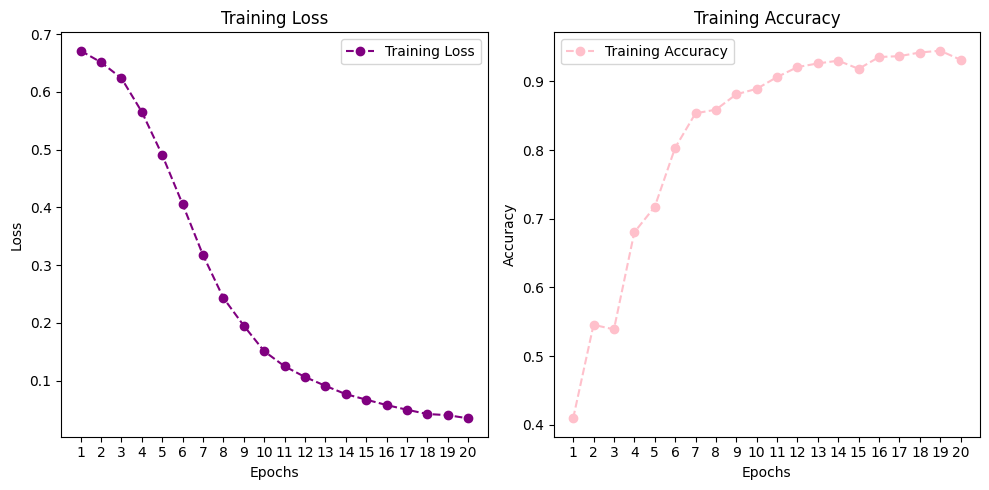

In [1]:
import matplotlib.pyplot as plt

# Define the values from your training
loss_values = [0.6713, 0.6512, 0.6237, 0.5653, 0.4907, 0.4056, 0.3175, 0.2433, 0.1953, 0.1511, 
               0.1250, 0.1065, 0.0912, 0.0768, 0.0673, 0.0579, 0.0498, 0.0424, 0.0404, 0.0349]
accuracy_values = [0.4095, 0.5456, 0.5390, 0.6803, 0.7173, 0.8032, 0.8534, 0.8587, 0.8811, 0.8890, 
                   0.9062, 0.9207, 0.9260, 0.9300, 0.9181, 0.9353, 0.9366, 0.9419, 0.9445, 0.9313]

# Create a plot
plt.figure(figsize=(10, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(loss_values) + 1), loss_values, 'bo--', label='Training Loss', color='purple')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Set ticks for whole number epochs
plt.xticks(range(1, len(loss_values) + 1))

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(accuracy_values) + 1), accuracy_values, 'ro--', label='Training Accuracy', color='pink')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Set ticks for whole number epochs
plt.xticks(range(1, len(accuracy_values) + 1))

plt.tight_layout()
plt.show()
